### Project Title : Classification model for predicting MIS_Status using SBA Loans data
#### Name : Megha Chandrasekharan Nair
#### UTDID : mxc220113

#### <span style="color: lightgreen;">Project Goal:This notebook deals with model training. The agenda is to train one model using either H2O GBM or XgBoost which will classify the MIS_Status of SBA loans records as 0 or 1. 1 being the loan gets defaulted and 0 being the loan is paid in full.It includes step by step processes of data cleaning, preprocessing, handling categorical columns, model training,hypertuning and also gives a summary of the best model chosen from hypertuning. It also involves explaining the model using SHAP summary,permutation feature importances and residual analysis. I have chosen H2O GBM to train my model for this project.</span> ###

##### Step 1: <span style="color:yellow;font-style:italic">Import all the required libraries needed to run the model.</span>

In [1]:
import pandas as pd;
import numpy as np;
import warnings;
warnings.filterwarnings("ignore");
import pickle;
import inspect;
import pandas.api.types as ptypes
import h2o
from h2o.estimators import H2OTargetEncoderEstimator
try:
    h2o.cluster().shutdown()
except:
    pass
#Limit to 3 threads and 8GB memory
h2o.init(nthreads=-1,max_mem_size='8G')

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,40 mins 29 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,7 months and 18 days
H2O_cluster_name:,H2O_from_python_megha_tdz8mm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,299.7 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


##### Step 2: <span style="color:yellow;font-style:italic">Read data from the csv file named "SBA_loans_project_1.csv" into a variable named data_full</span>

In [2]:
data_full = pd.read_csv("data/SBA_loans_project_2.csv")
data_full.head()

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
0,0,FORT LEE,NJ,7024,BNB HANA BANK NATL ASSOC,NJ,425120,2,1.0,0,2,1,1,Y,N,10000.0,0.0,10000.0,5000.0,0
1,1,WESTWEGO,LA,70094,JEDCO DEVELOPMENT CORPORATION,LA,812331,62,1.0,6,0,1,1,0,N,353000.0,0.0,353000.0,353000.0,0
2,2,DENVER,CO,80209,WELLS FARGO BANK NATL ASSOC,SD,541611,4,1.0,1,4,1,1,Y,N,100000.0,0.0,100000.0,50000.0,0
3,3,WRANGELL,AK,99929,FIRST BANK,AK,446110,3,2.0,0,0,1,0,N,Y,75000.0,0.0,75000.0,67500.0,0
4,4,MALVERN,AR,72104,CITICAPITAL SMALL BUS. FINANCE,TX,0,1,2.0,0,0,52000,1,0,Y,45000.0,0.0,45000.0,36000.0,1


##### Step 3: <span style="color:yellow;font-style:italic">Lets describe the data to observe the factors that might impact our model(like ranges of each column,identify skewness which might indicate outliers,need for scaling etc.) so that we can take effective steps to get the best model.</span>

In [3]:
data_full.describe()

,index,Zip,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
count,799356.000000,799356.000000,799356.000000,799356.000000,799242.000000,799356.000000,799356.000000,799356.000000,799356.000000,7.993560e+05,799356.000000,7.993560e+05,7.993560e+05,799356.000000
mean,399677.500000,53800.147424,398464.725004,11.394357,1.280437,8.483066,10.845923,2760.209924,0.757724,2.013042e+05,3.241368,1.928171e+05,1.495953e+05,0.175147
std,230754.345227,31185.719099,263323.979801,73.987319,0.451807,237.721677,238.151620,12773.508716,0.646558,2.874362e+05,1525.703507,2.831258e+05,2.282590e+05,0.380093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000e+02,1.000000e+02,0.000000
25%,199838.750000,27562.750000,235210.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.200000e+04,0.000000,3.500000e+04,2.125000e+04,0.000000
50%,399677.500000,55410.000000,445310.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+05,0.000000,9.000000e+04,6.160000e+04,0.000000
75%,599516.250000,83704.000000,561730.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000,2.384595e+05,0.000000,2.250000e+05,1.750000e+05,0.000000
max,799355.000000,99999.000000,928120.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000,1.100000e+07,996262.000000,5.472000e+06,5.472000e+06,1.000000


In [4]:
artifacts_dict = {}
artifacts_functions = {}# creating a dictionary which will store the intermediate outputs and functions which can be
#dumped into artifacts folder and later retreived and reused in the scoring function.

#### Step 4: <span style="color:yellow;font-style:italic">These are the datacleaning functions following the data description in the attached kaggle link given in the project-starter file</span>
<ul style="color:orange">
    <li>We fill missing values in numerical columns to 0 and "Missing" for the categorical columns.</li>
    <li>We need to classify if a loan is for a Franchise or a non-franchise. A code greater than 1 indicates its a franchise</li>
    <li>Classifying if its a new business or an existing business.</li>
    <li>Classifying if the loan was disbursed as a revolving line of credit or not</li>
    <li>Classifying if its a Urban or a rural business</li>
    <li>Classifying if the loan was approved with low documentation</li>
    <li>We classify NAICS column based on their economic sectors. The first two digits of the NAICS code stands for the sector.</li>
</ul>

In [5]:
#Below function is to extract first two digits of NAICS which represents a sector. Few sectors have multiple two digit codes,which is handled below.
def get_naics(x):
        x = int(str(x)[:2])
        if x == 0:
            return "Missing" # No valid NAICS code interpreted as missing
        elif 31 <= x <= 33:
            return str(31) # Manufacturing sector
        elif 44 <= x <= 45:
            return str(44) # Retail trade
        elif 48 <= x <= 49:
            return str(48) #Transportation and warehousing
        else:
            return str(x)
artifacts_functions["get_naics"] = inspect.getsource(get_naics) #storing the function into artifacts dictionary

#Below function is to fill missing values. 0 for numerical and Missing for categorical.
def fillMissingValues(inputdata):
    for col in inputdata.columns:
        if(inputdata[col].isna().sum()>0):
            if(ptypes.is_numeric_dtype(inputdata[col])):
                inputdata[col].fillna(0,inplace=True)
            else:
                inputdata[col].fillna("Missing",inplace=True)
artifacts_functions["fillMissingValues"] = inspect.getsource(fillMissingValues) #storing the function into the artifacts dict

#Below function cleans the Franchisecode,RevLineCr,NewExist,UrbanRural,LowDoc and NAICS columns
def data_clean_preprocess(inputdata):
    #franchise if a code > 1 else not a franchise
    inputdata["FranchiseCode"] = inputdata["FranchiseCode"].apply(lambda x: 0 if (x == 0 or x == 1) else 1)
    #new business if value is 0 else existing business
    inputdata["NewExist"] = inputdata["NewExist"].apply(lambda x: 0 if (x==1 or x==0) else 1)
    #Valid values are only 'Y','N' rest are considered Missing
    inputdata["RevLineCr"] = inputdata["RevLineCr"].apply(lambda x: 'Y' if (x == 'Y' or x == 1) else ('N' if (x == 'N'  or x==0) else 'Missing'))
    #Value 1 indicates 'Urban', 2 indicates 'Rural' else missing
    inputdata["UrbanRural"] = inputdata["UrbanRural"].apply(lambda x: 'Urban' if (x == 1) else ('Rural' if (x==2) else 'Missing'))
    #Valid values are only 'Y','N' rest are considered Missing
    inputdata["LowDoc"] = inputdata["LowDoc"].apply(lambda x: 'Y' if (x == 'Y' or x == 1) else ('N' if (x == 'N'  or x==0) else 'Missing'))
    #Apply sectors to NAICS column
    inputdata['NAICS'] = inputdata['NAICS'].apply(get_naics)
    inputdata['Zip'] = inputdata['Zip'].apply(lambda x: str(x)[:4])
    #Set category types to the columns.
    inputdata[["Zip","NewExist","FranchiseCode",
               "UrbanRural","RevLineCr","NAICS","LowDoc"]] = inputdata[["Zip","NewExist","FranchiseCode","UrbanRural"
                                                                        ,"RevLineCr","NAICS","LowDoc"]].astype('category')
    #fill missing values
    fillMissingValues(inputdata)

artifacts_functions["data_clean_preprocess"] = inspect.getsource(data_clean_preprocess) # store the function in the dictionary

#### Step 5: <span style="color:yellow;font-style:italic">Let us define the target column and split the data into training,test and validation datasets</span>

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,RobustScaler
#from category_encoders import WOEEncoder,TargetEncoder
X = data_full
Y = data_full['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#### Step 6: <span style="color:yellow;font-style:italic">As suggested in project starter,applying data cleaning to training,test and validation datasets</span>

In [7]:
#We will apply the cleaning function into the data
data_clean_preprocess(X_train)
data_clean_preprocess(X_val)
data_clean_preprocess(X_test)

#### Step 7:<span style="color:yellow"> Let us create a default model with the training data to check how the model performs before feature engineering. So as to make sure the features that we add contribute to the final model</span>

In [10]:
catcolumns = []
for col in X_train.columns:
    if(ptypes.is_numeric_dtype(X_train[col])):
        continue; # if a column is numeric skip
    else: # else store as categorical
        catcolumns.append(col)

h2o_basetrain = h2o.H2OFrame(X_train)
h2o_baseval = h2o.H2OFrame(X_val)
h2o_basetest = h2o.H2OFrame(X_test)

# Specify the response and predictor variables (replace 'response_column' and 'predictor_columns' accordingly)
response = 'MIS_Status'
predictors = h2o_basetrain.columns
predictors.remove(response)
predictors.remove('index')
h2o_basetrain[catcolumns+[response]]= h2o_basetrain[catcolumns+[response]].asfactor()
h2o_baseval[catcolumns+[response]] = h2o_baseval[catcolumns+[response]].asfactor()
h2o_basetest[catcolumns+[response]] = h2o_basetest[catcolumns+[response]].asfactor()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
# Train the H2O Gradient Boosting Estimator
basegbm = H2OGradientBoostingEstimator(
    nfolds=0,
    ntrees=500,
    max_depth=5,
    stopping_rounds=10,
    stopping_metric='AUC',
    stopping_tolerance=0.01,
    learn_rate=0.1,
    sample_rate=1.0,
    min_rows=10,
    seed=1234,
    keep_cross_validation_predictions=False
)

# Train the model
basegbm.train(x=predictors, y=response, training_frame=h2o_basetrain,validation_frame=h2o_baseval);
# Display model performance on the test dataset
print(basegbm.model_performance(h2o_baseval))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.11414909936764546
RMSE: 0.33785958528306614
LogLoss: 0.3708867366060659
Mean Per-Class Error: 0.28418229096982156
AUC: 0.8001857845703743
AUCPR: 0.5110456747677057
Gini: 0.6003715691407485

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23621703736694294
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      110654  21127  0.1603   (21127.0/131781.0)
1      11462   16628  0.408    (11462.0/28090.0)
Total  122116  37755  0.2038   (32589.0/159871.0)

Maximum Metrics: Maximum metrics at their respective thres

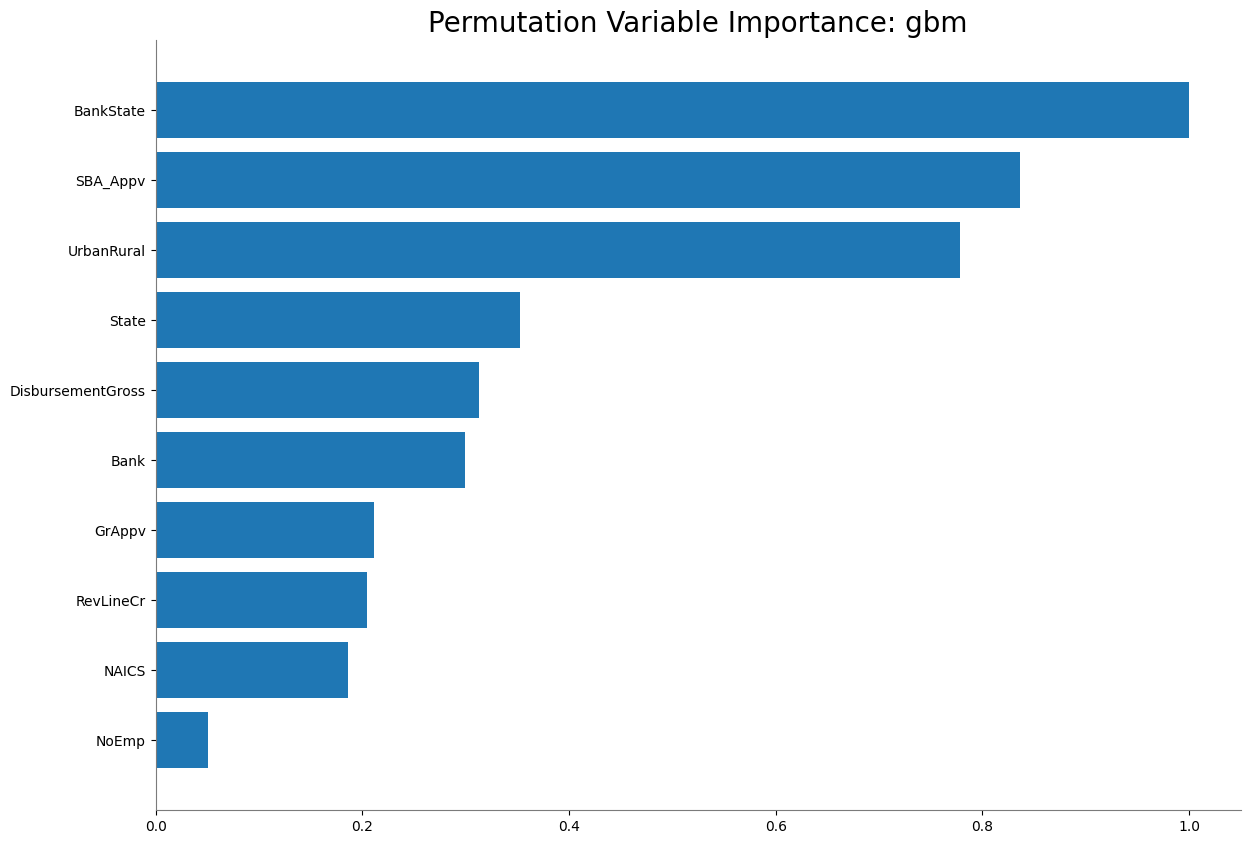

Variable,Relative Importance,Scaled Importance,Percentage
BankState,0.0754286,1.0,0.2306901
SBA_Appv,0.0630528,0.8359276,0.1928403
UrbanRural,0.0586804,0.7779602,0.1794678
State,0.0265819,0.3524118,0.0812979
DisbursementGross,0.0236194,0.3131361,0.0722374
Bank,0.0225602,0.2990932,0.0689978
GrAppv,0.0159028,0.2108327,0.0486370
RevLineCr,0.0154117,0.2043219,0.0471350
NAICS,0.0140394,0.1861287,0.0429380
NoEmp,0.0038226,0.0506784,0.0116910


In [11]:
basegbm.permutation_importance_plot(h2o_baseval)

#### Summary of the base model:
We can see that a default model without any engineered features has AUC of 0.80 and F1 score of 0.5. Our goal is to produce new features and perform hypertuning to increase the model performance. From the permution importance plot, we can understand that by combining few top features like BankState,UrbanRural and SBA_Appv we can increase the model performance

#### Step 8: <span style="color:yellow;font-style:italic">Create engineered features</span>
<ol style="color:orange">
    <li>Bank Loan Count: Number of loans that are given by a bank.High number might indicate that bank's experience in dealing with deafults.</li>
    <li>SBA_Appv interactions created with State,Bank,BankState,UrbanRural,FranchiseCode,NAICS and NewExist features</li>
    <li>BankState interactions created with Bank,State,FranchiseCode,NewExist,UrbanRural</li>
    <li>SBA_Dis_Ratio:  Ratio between SBA_Appv and DisbursementGross</li>
    <li>SBA_Gr_Ratio:  Ratio between SBA_Appv and GrAppv</li>
    <li>Dis_Gr_Ratio:  Ratio between DisbursementGross and GrAppv</li>
    <li>DisSbaDiff: If Disbursement is greater than the SBA_Appv coverage amount.</li>
    <li>Total of 6 Interaction features are created between categorical variables RevLineCr,LowDoc,UrbanRural and NewExist</li>
    <li>State Interaction features created with UrbanRural,FranchiseCode and NewExist</li>
    <li>NAICS Interaction features created with UrbanRural,FranchiseCode,Bank and BankState</li>
</ol>

Further steps are taken to store the values mapped to the train data into dictionary so as to reuse them for creating engineered features for validation and test data.

In [12]:
#The below values are taken only from the training data and hence has to stored in the artifacts dictionary
#as they have to be resused for mapping in the scoring
artifacts_dict['bank_loan_counts'] = X_train['Bank'].value_counts().to_dict()
artifacts_dict['BankState_sbaAppv'] = X_train.groupby('BankState')['SBA_Appv'].mean().to_dict()
artifacts_dict['UrbanRural_sbaAppv'] = X_train.groupby('UrbanRural')['SBA_Appv'].mean().to_dict()
artifacts_dict['State_sbaAppv'] = X_train.groupby('State')['SBA_Appv'].mean().to_dict()
artifacts_dict['Bank_sbaAppv'] = X_train.groupby('Bank')['SBA_Appv'].mean().to_dict()
artifacts_dict['bankperformance_ur'] = X_train.groupby(['Bank','UrbanRural'])['SBA_Appv'].mean().to_dict()
X_train["Bank_UR"] = X_train.apply(lambda row: artifacts_dict["bankperformance_ur"].get((row['Bank'], row['UrbanRural']), 0), axis=1)
artifacts_dict['bankstateperformance_ur'] = X_train.groupby(['BankState','UrbanRural'])['SBA_Appv'].mean().to_dict()
X_train["BankState_UR"] = X_train.apply(lambda row: artifacts_dict["bankstateperformance_ur"].get((row['BankState'], row['UrbanRural']), 0), axis=1)
artifacts_dict['bankstateperformance_naics'] = X_train.groupby(['BankState','NAICS'])['SBA_Appv'].mean().to_dict()
X_train["BankState_NAICS"] = X_train.apply(lambda row: artifacts_dict["bankstateperformance_naics"].get((row['BankState'], row['NAICS']), 0), axis=1)
artifacts_dict['stateperformance_naics'] = X_train.groupby(['State','NAICS'])['SBA_Appv'].mean().to_dict()
X_train["State_NAICS"] = X_train.apply(lambda row: artifacts_dict["stateperformance_naics"].get((row['State'], row['NAICS']), 0), axis=1)
artifacts_dict['Bankperformance_naics'] = X_train.groupby(['Bank','NAICS'])['SBA_Appv'].mean().to_dict()
X_train["Bank_NAICS"] = X_train.apply(lambda row: artifacts_dict["Bankperformance_naics"].get((row['Bank'], row['NAICS']), 0), axis=1)
artifacts_dict['URperformance_naics'] = X_train.groupby(['NAICS',"UrbanRural"])['SBA_Appv'].mean().to_dict()
X_train["URperformance_naics"] = X_train.apply(lambda row: artifacts_dict["URperformance_naics"].get((row['NAICS'], row['UrbanRural']), 0), axis=1)
artifacts_dict['Franchiseperformance_naics'] = X_train.groupby(['NAICS',"FranchiseCode"])['SBA_Appv'].mean().to_dict()
X_train["Franchiseperformance_naics"] = X_train.apply(lambda row: artifacts_dict["Franchiseperformance_naics"].get((row['NAICS'], row['FranchiseCode']), 0), axis=1)
artifacts_dict['Franchiseperformance_Bank'] = X_train.groupby(['Bank',"FranchiseCode"])['SBA_Appv'].mean().to_dict()
X_train["Franchiseperformance_Bank"] = X_train.apply(lambda row: artifacts_dict["Franchiseperformance_Bank"].get((row['Bank'], row['FranchiseCode']), 0), axis=1)
artifacts_dict['NewExistperformance_Bank'] = X_train.groupby(['Bank',"NewExist"])['SBA_Appv'].mean().to_dict()
X_train["NewExistperformance_Bank"] = X_train.apply(lambda row: artifacts_dict["NewExistperformance_Bank"].get((row['Bank'], row['NewExist']), 0), axis=1)
artifacts_dict['Franchiseperformance_BankState'] = X_train.groupby(['BankState',"FranchiseCode"])['SBA_Appv'].mean().to_dict()
X_train["Franchiseperformance_BankState"] = X_train.apply(lambda row: artifacts_dict["Franchiseperformance_BankState"].get((row['BankState'], row['FranchiseCode']), 0), axis=1)
artifacts_dict['NewExistperformance_BankState'] = X_train.groupby(['BankState',"NewExist"])['SBA_Appv'].mean().to_dict()
X_train["NewExistperformance_BankState"] = X_train.apply(lambda row: artifacts_dict["NewExistperformance_BankState"].get((row['BankState'], row['NewExist']), 0), axis=1)
artifacts_dict['BankURMean'] = X_train["Bank_UR"].mean()
artifacts_dict['BankStateURMean'] = X_train["BankState_UR"].mean()
artifacts_dict['BankStateNAICSMean'] = X_train["BankState_NAICS"].mean()
artifacts_dict['StateNAICSMean'] = X_train["State_NAICS"].mean()
artifacts_dict['BankNAICSMean'] = X_train["Bank_NAICS"].mean()
artifacts_dict['URperformance_naicsMean'] = X_train["URperformance_naics"].mean()
artifacts_dict['Franchiseperformance_naicsMean'] = X_train["Franchiseperformance_naics"].mean()
artifacts_dict['Franchiseperformance_BankMean'] = X_train["Franchiseperformance_Bank"].mean()
artifacts_dict['NewExistperformance_BankMean'] = X_train["NewExistperformance_Bank"].mean()
artifacts_dict['Franchiseperformance_BankStateMean'] = X_train["Franchiseperformance_BankState"].mean()
artifacts_dict['NewExistperformance_BankStateMean'] = X_train["NewExistperformance_BankState"].mean()

#a function that will create all the above listed interaction features for any input dataframe.
def create_engineered_features(inputdata,artifacts_dict):
    inputdata['BankLoanCount'] = inputdata['Bank'].map(artifacts_dict["bank_loan_counts"]).fillna(0)
    inputdata['Bank_BankState'] =  inputdata["Bank"].astype(str)+"_"+inputdata["BankState"].astype(str)
    inputdata['isSameState'] =  (inputdata["State"]==inputdata["BankState"]).astype(int)
    inputdata['BankState_sbaAppv'] = inputdata["BankState"].map(artifacts_dict["BankState_sbaAppv"])
    inputdata['State_sbaAppv'] = inputdata["State"].map(artifacts_dict["BankState_sbaAppv"])
    inputdata['Bank_sbaAppv'] = inputdata["Bank"].map(artifacts_dict["Bank_sbaAppv"])
    inputdata['SBA_Disb_Ratio'] = inputdata["SBA_Appv"]/(inputdata["DisbursementGross"]+1)
    inputdata['SBA_Gr_Ratio'] = inputdata["SBA_Appv"]/(inputdata["GrAppv"]+1)
    inputdata['Dis_Gr_Ratio'] = inputdata["DisbursementGross"]/inputdata["GrAppv"]
    inputdata["SBADisbDiff"] = (inputdata["SBA_Appv"] > inputdata["DisbursementGross"]).astype(int)
    inputdata["BankState_UrbanRural"] = inputdata["BankState"].astype(str)+"_"+inputdata["UrbanRural"].astype(str)
    inputdata["State_UrbanRural"] = inputdata["State"].astype(str)+"_"+inputdata["UrbanRural"].astype(str)
    inputdata['LoanToEmployeeRatio'] = inputdata['GrAppv'] / (inputdata['NoEmp']+1)
    inputdata["Bank_UR"] = inputdata.apply(lambda row: artifacts_dict["bankperformance_ur"].get((row['Bank'], row['UrbanRural']), 0), axis=1)
    inputdata["Bank_UR"].fillna(artifacts_dict["BankURMean"],inplace=True)
    inputdata["BankState_UR"] = inputdata.apply(lambda row: artifacts_dict["bankstateperformance_ur"].get((row['BankState'], row['UrbanRural']), 0), axis=1)
    inputdata["BankState_UR"].fillna(artifacts_dict["BankStateURMean"],inplace=True)
    inputdata["BankState_NAICS"] = inputdata.apply(lambda row: artifacts_dict["bankstateperformance_naics"].get((row['BankState'], row['NAICS']), 0), axis=1)
    inputdata["BankState_NAICS"].fillna(artifacts_dict["BankStateNAICSMean"],inplace=True)
    inputdata["State_NAICS"] = inputdata.apply(lambda row: artifacts_dict["stateperformance_naics"].get((row['State'], row['NAICS']), 0), axis=1)
    inputdata["State_NAICS"].fillna(artifacts_dict["StateNAICSMean"],inplace=True)
    inputdata["Bank_NAICS"] = inputdata.apply(lambda row: artifacts_dict["Bankperformance_naics"].get((row['Bank'], row['NAICS']), 0), axis=1)
    inputdata["Bank_NAICS"].fillna(artifacts_dict["BankNAICSMean"],inplace=True)
    inputdata["URperformance_naics"] = inputdata.apply(lambda row: artifacts_dict["URperformance_naics"].get((row['NAICS'], row['UrbanRural']), 0), axis=1)
    inputdata["URperformance_naics"].fillna(artifacts_dict["URperformance_naicsMean"],inplace=True)
    inputdata["Franchiseperformance_naics"] = inputdata.apply(lambda row: artifacts_dict["Franchiseperformance_naics"].get((row['NAICS'], row['FranchiseCode']), 0), axis=1)
    inputdata["Franchiseperformance_naics"].fillna(artifacts_dict["Franchiseperformance_naicsMean"],inplace=True)
    inputdata["Franchiseperformance_Bank"] = inputdata.apply(lambda row: artifacts_dict["Franchiseperformance_Bank"].get((row['Bank'], row['FranchiseCode']), 0), axis=1)
    inputdata["Franchiseperformance_Bank"].fillna(artifacts_dict["Franchiseperformance_BankMean"],inplace=True)
    inputdata["NewExistperformance_Bank"] = inputdata.apply(lambda row: artifacts_dict["NewExistperformance_Bank"].get((row['Bank'], row['NewExist']), 0), axis=1)
    inputdata["NewExistperformance_Bank"].fillna(artifacts_dict["NewExistperformance_BankMean"],inplace=True)
    inputdata["Franchiseperformance_BankState"] = inputdata.apply(lambda row: artifacts_dict["Franchiseperformance_BankState"].get((row['BankState'], row['FranchiseCode']), 0), axis=1)
    inputdata["Franchiseperformance_BankState"].fillna(artifacts_dict["Franchiseperformance_BankStateMean"],inplace=True)
    inputdata["NewExistperformance_BankState"] = inputdata.apply(lambda row: artifacts_dict["NewExistperformance_BankState"].get((row['BankState'], row['NewExist']), 0), axis=1)
    inputdata["NewExistperformance_BankState"].fillna(artifacts_dict["NewExistperformance_BankStateMean"],inplace=True)
    inputdata["CreateNoEmp"] = inputdata["CreateJob"]/(inputdata["NoEmp"]+1)
    inputdata["NewExist_RevLineCr"] = inputdata["NewExist"].astype(str)+"_"+inputdata["RevLineCr"].astype(str)
    inputdata["UrbanRural_RevLineCr"] = inputdata["UrbanRural"].astype(str)+"_"+inputdata["RevLineCr"].astype(str)
    inputdata["LowDoc_RevLineCr"] = inputdata["LowDoc"].astype(str)+"_"+inputdata["RevLineCr"].astype(str)
    inputdata["LowDoc_NewExist"] = inputdata["LowDoc"].astype(str)+"_"+inputdata["NewExist"].astype(str)
    inputdata["UrbanRural_LowDoc"] = inputdata["UrbanRural"].astype(str)+"_"+inputdata["LowDoc"].astype(str)
    inputdata["UrbanRural_NewExist"] = inputdata["UrbanRural"].astype(str)+"_"+inputdata["NewExist"].astype(str)
    inputdata["DisbursementGross"] = np.log(inputdata["DisbursementGross"])
    inputdata["GrAppv"] = np.log(inputdata["GrAppv"])
    inputdata["SBA_Appv"] = np.log(inputdata["SBA_Appv"])
    inputdata['Bank_UR'] = pd.to_numeric(inputdata['Bank_UR'],errors='coerce')
    inputdata['Bank_sbaAppv'] =  pd.to_numeric(inputdata['Bank_sbaAppv'],errors='coerce')
    inputdata['BankState_sbaAppv'] =  pd.to_numeric(inputdata['BankState_sbaAppv'],errors='coerce')
    inputdata['State_sbaAppv'] =  pd.to_numeric(inputdata['State_sbaAppv'],errors='coerce')
    inputdata['BankState_UR'] = pd.to_numeric(inputdata['BankState_UR'],errors='coerce')
    inputdata['BankState_NAICS'] = pd.to_numeric(inputdata['BankState_NAICS'],errors='coerce')
    inputdata['State_NAICS'] = pd.to_numeric(inputdata['State_NAICS'],errors='coerce')
    inputdata['Bank_NAICS'] = pd.to_numeric(inputdata['Bank_NAICS'],errors='coerce')

    #Once features are created,filling missing values.
    fillMissingValues(inputdata)
artifacts_functions["create_engineered_features"] = inspect.getsource(create_engineered_features) #store the function into the dictionary

In [13]:
#pass all the dataframes for creating the required engineered features
create_engineered_features(X_train,artifacts_dict)
create_engineered_features(X_val,artifacts_dict)
create_engineered_features(X_test,artifacts_dict)

In [14]:
X_test = X_test.reset_index(drop=True)

#### Step 9: <span style="color:yellow">Load the cleaned and preprocessed data into h2oframe train,validation and test dataframes.</span>

In [15]:
h2o_train = h2o.H2OFrame(X_train)
h2o_val = h2o.H2OFrame(X_val)
h2o_test = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [16]:
h2o_train.head(5)

index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Bank_UR,BankState_UR,BankState_NAICS,State_NAICS,Bank_NAICS,URperformance_naics,Franchiseperformance_naics,Franchiseperformance_Bank,NewExistperformance_Bank,Franchiseperformance_BankState,NewExistperformance_BankState,BankLoanCount,Bank_BankState,isSameState,BankState_sbaAppv,State_sbaAppv,Bank_sbaAppv,SBA_Disb_Ratio,SBA_Gr_Ratio,Dis_Gr_Ratio,SBADisbDiff,BankState_UrbanRural,State_UrbanRural,LoanToEmployeeRatio,CreateNoEmp,NewExist_RevLineCr,UrbanRural_RevLineCr,LowDoc_RevLineCr,LowDoc_NewExist,UrbanRural_LowDoc,UrbanRural_NewExist
718563,SEYMOUR,TN,9999,AREAWIDE DEVEL CORP,TN,53,4,1,2,2,0,Rural,N,N,12.7008,0,12.7008,12.7008,0,578611,266032,188275,117466,228500,127098,122054,358022,447048,207833,221211,109,AREAWIDE DEVEL CORP_TN,1,225865,225865,398312,0.999997,0.999997,1,0,TN_Rural,TN_Rural,65600,0.4,1_N,Rural_N,N_N,N_1,Rural_N,Rural_1
263880,PORTER,TX,7736,WELLS FARGO BANK NATL ASSOC,CA,31,2,0,0,2,0,Urban,Missing,N,9.90349,0,9.90349,9.21034,0,129833,215620,310811,202575,195240,199714,210709,154777,162396,209229,231970,33936,WELLS FARGO BANK NATL ASSOC_CA,0,213373,229410,157429,0.499975,0.499975,1,0,CA_Urban,TX_Urban,6666.67,0,0_Missing,Urban_Missing,N_Missing,N_0,Urban_N,Urban_0
394661,POWAY,CA,9206,COMMUNITY W. BANK NATL ASSOC,CA,81,2,1,2,2,1,Urban,Missing,N,12.8713,0,12.8713,12.5837,1,262628,215620,176863,176869,237621,113088,150314,207878,204875,279338,148157,751,COMMUNITY W. BANK NATL ASSOC_CA,1,213373,213373,260598,0.749998,0.749998,1,0,CA_Urban,CA_Urban,129667,0.666667,1_Missing,Urban_Missing,N_Missing,N_1,Urban_N,Urban_1
23676,LACROSSE,WI,5460,ALTRA FCU,WI,51,4,1,0,0,0,Urban,N,N,12.2061,0,12.2061,11.9184,1,90249,157069,149972,120375,150000,92733.5,106477,151463,85053.1,178781,139665,13,ALTRA FCU_WI,1,182729,182729,151463,0.749996,0.749996,1,0,WI_Urban,WI_Urban,40000,0,1_N,Urban_N,N_N,N_1,Urban_N,Urban_1
146082,TYLER,TX,7570,SOUTHSIDE BANK,TX,81,1,0,0,1,0,Urban,Missing,N,12.1281,0,12.1281,11.8404,0,109039,266952,220948,172671,235392,113088,120614,116627,133521,221528,245667,98,SOUTHSIDE BANK_TX,1,229410,229410,114197,0.749996,0.749996,1,0,TX_Urban,TX_Urban,92500,0,0_Missing,Urban_Missing,N_Missing,N_0,Urban_N,Urban_0


#### Step 10: <span style="color:yellow">Create a list of categorical columns to apply asfactor  to those columns.</span>

In [17]:
artifacts_dict["CategoricalColumns"] = []
for col in X_train.columns:
    if(ptypes.is_numeric_dtype(X_train[col])):
        continue; # if a column is numeric skip
    else: # else store as categorical
        artifacts_dict["CategoricalColumns"].append(col)

#### Step 11: <span style="color:yellow">Define predictor and reponse columns that should be used in the model. Index column is removed from the predictors as its not a valid predictor.</span>

In [18]:
# Specify the response and predictor variables (replace 'response_column' and 'predictor_columns' accordingly)
response = 'MIS_Status'
predictors = h2o_train.columns
predictors.remove(response)
predictors.remove('index')
h2o_train[artifacts_dict["CategoricalColumns"]+[response]]= h2o_train[artifacts_dict["CategoricalColumns"]+[response]].asfactor()
h2o_val[artifacts_dict["CategoricalColumns"]+[response]] = h2o_val[artifacts_dict["CategoricalColumns"]+[response]].asfactor()
h2o_test[artifacts_dict["CategoricalColumns"]+[response]] = h2o_test[artifacts_dict["CategoricalColumns"]+[response]].asfactor()

#### Step 12: <span style="color:yellow">Create a default model with random parameters to check how the model works.</span>

In [19]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
# Train the H2O Gradient Boosting Estimator
gbm = H2OGradientBoostingEstimator(
    nfolds=0,
    ntrees=500,
    max_depth=5,
    stopping_rounds=10,
    stopping_metric='AUC',
    stopping_tolerance=0.01,
    learn_rate=0.1,
    sample_rate=1.0,
    min_rows=10,
    seed=1234,
    keep_cross_validation_predictions=False
)

# Train the model
gbm.train(x=predictors, y=response, training_frame=h2o_train,validation_frame=h2o_val);
# Display model performance on the test dataset
print(gbm.model_performance(h2o_val))

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.11055996338660619
RMSE: 0.33250558399312063
LogLoss: 0.35655560175222717
Mean Per-Class Error: 0.2716892441071087
AUC: 0.8207936901279159
AUCPR: 0.5371725844927573
Gini: 0.6415873802558318

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24093312034123307
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      111601  20180  0.1531   (20180.0/131781.0)
1      10962   17128  0.3902   (10962.0/28090.0)
Total  122563  37308  0.1948   (31142.0/159871.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.240933     0.523808  225
max f2                       0.128271     0.633458  297
max f0point5                 0.434624     0.539198  1

#### Our basic model has given an AUC of 0.82 and F1 score 0.52 on validation which is a good score and an incraese from the deafault model. This indicates that the new features that we added are contributing to increased model performance.The overall error rate is 19.4% which is observed from the confusion matrix.Since the performance metric that we are interested in is AUC we will just concentrate on that and do the further hypertuning.

#### Step 13: <span style="color:yellow">Hyper tune the GBM with hyper parameters and find the best parameters. I have chosen 72 models.</span>

In [17]:
from h2o.grid.grid_search import H2OGridSearch
hyper_gbm = H2OGradientBoostingEstimator(
    nfolds=0,
    stopping_rounds=10,
    stopping_metric='AUC',
    stopping_tolerance=0.01,
    seed=1234,
    keep_cross_validation_predictions=False)

# Define the hyperparameters to search
hyper_params = {
    'ntrees': [500], # 1
    'max_depth': [5,7,10,15], #4
    'learn_rate': [0.005,0.01,0.1],#12
    'sample_rate': [0.5,1.0],#24
    'min_rows':[10,15,20],#72
}
# Perform grid search
grid = H2OGridSearch(model=hyper_gbm,parallelism=100,hyper_params=hyper_params)
grid.train(x=predictors, y=response, training_frame=h2o_train, validation_frame=h2o_val)

# Get the grid results
grid_results = grid.get_grid(sort_by='auc',decreasing=True)
#print(grid_results)

# Get the best model
best_model = grid_results.models[0]
print(best_model)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_1723001999155_72


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    83                 83                          944837                 0            10           9.87952       1             766           516.47

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08915137786733825
RMSE: 0.2985822798950705
LogLoss: 0.29406224266649517
Mean Per-Class Error: 0.20734309839857978
AUC: 0.8962336804423405
AUCPR: 0.6966284727580053
Gini: 0.7924673608846811

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.288319146

#### Interpretation<br/>Error Rates:<br/>The overall error rate of the model is 17.95%.<br/>The model misclassifies 12.79% of the negative class (Actual 0) and 42.19% of the positive class (Actual 1).<br/>AUC:<br/>The model achieves an AUC of 0.8271, indicating good discriminative ability between the classes and an increase in AUC from our base model

#### Step 13: <span style="color:yellow">Check the AUC Score of the test data.</span>

In [19]:
best_model.model_performance(h2o_test).auc()

0.8265346111402933

#### Step 14: <span style="color:yellow">Plotting permutation importance of the features to understand which features impact the target the modet</span>

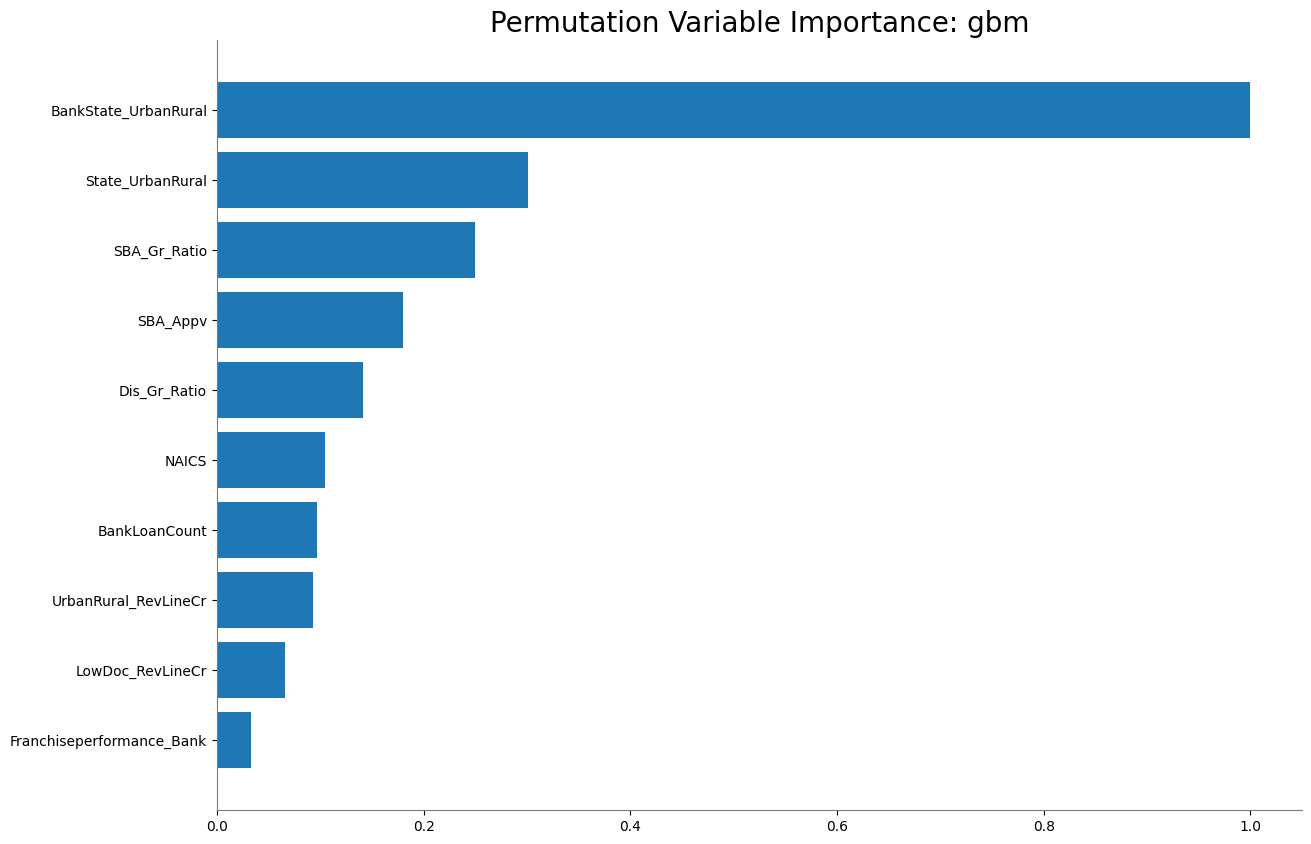

Variable,Relative Importance,Scaled Importance,Percentage
BankState_UrbanRural,0.1508638,1.0,0.3994160
State_UrbanRural,0.0453551,0.3006360,0.1200788
SBA_Gr_Ratio,0.0376000,0.2492312,0.0995469
SBA_Appv,0.0271799,0.1801621,0.0719596
Dis_Gr_Ratio,0.0213682,0.1416392,0.0565730
NAICS,0.0157801,0.1045982,0.0417782
BankLoanCount,0.0146212,0.0969164,0.0387099
UrbanRural_RevLineCr,0.0139767,0.0926444,0.0370036
LowDoc_RevLineCr,0.0099200,0.0657549,0.0262635
Franchiseperformance_Bank,0.0050016,0.0331530,0.0132419


In [20]:
best_model.permutation_importance_plot(h2o_test)

#### <section style="color:lightyellow">This plot shows the permutation variable importance of the best model on test data. Permutation feature importance gives the importance of a feature towards the model's predictive power. Higher the rank more important the feature is. The plot just gives the importance of the features but not the direction of their contribution(positive or negative impact) <br/> The plot suggests that the combination of bank location (urban/rural) and state of the bank is the strongest predictor of MIS_Status, followed by the state's urban/rural classification.<br/>  Financial ratios and approval amounts are the next important predictors.<br/> NAICS,FranchiseCode and RevLineCr interactions tend to have moderate importance.<br/> BalanceGross has the least/no importance in the model and ideally can be removed in practical scenarios.<br/>  But, here lets not drop the column BalanceGross as it is expected not to drop any columns.<br/> The plot also suggests that the feature engineering that was done has contributed to the model's predictive power as we can see that most of the higher ranked features are the engineered features.</section>

#### Step 15: <span style="color:yellow">SHAP summary plot to understand how different features contribute to the prediction of the target variable.To understand if a feature's value has a positive impact or a negative impact.</span>

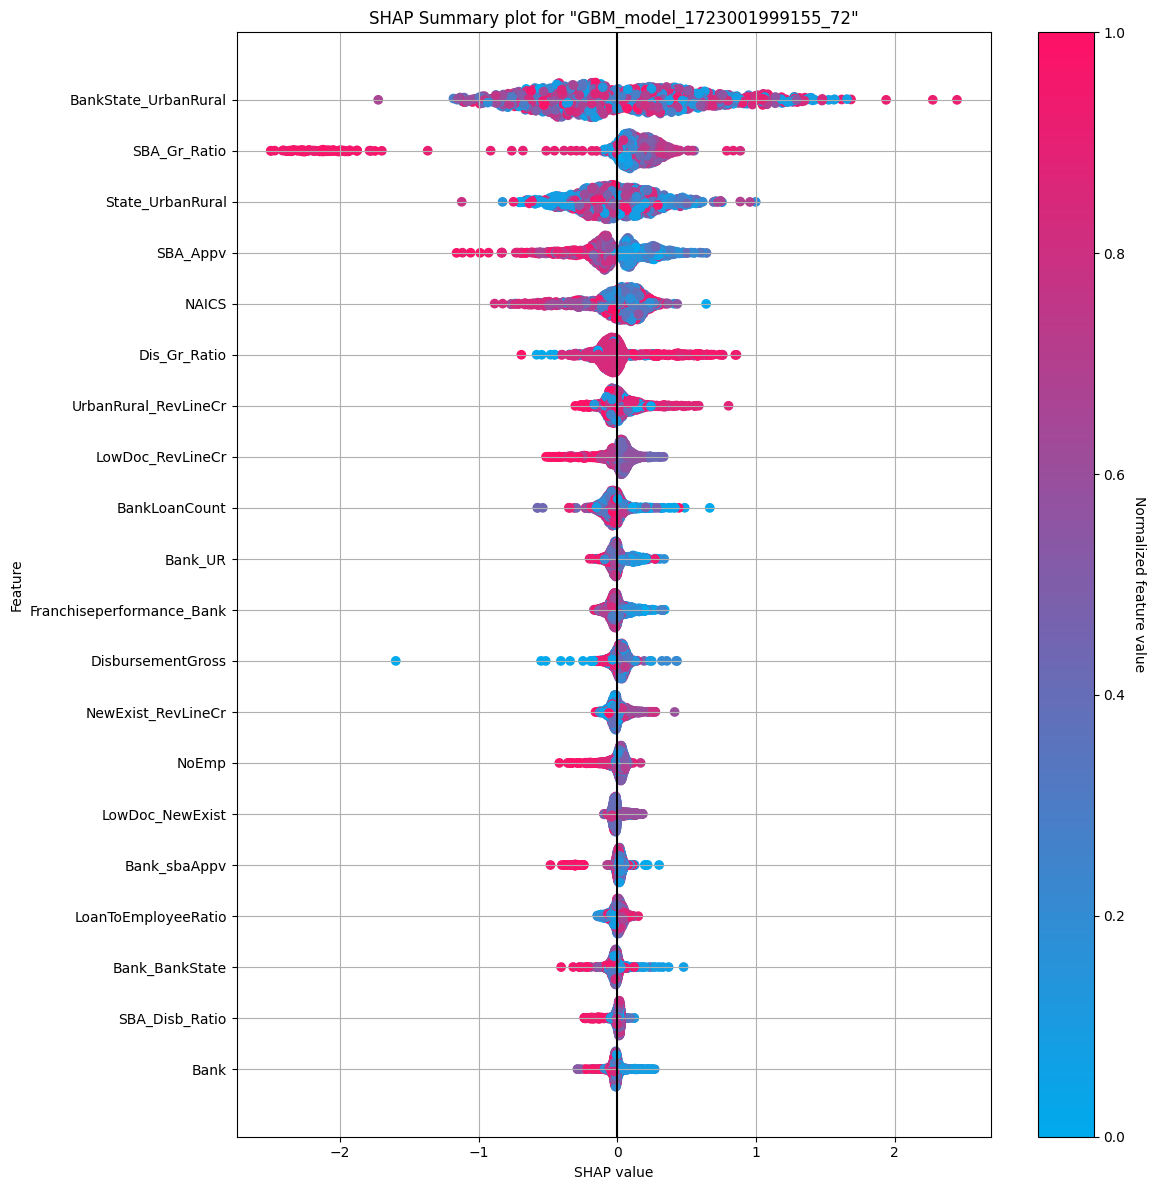

In [21]:
best_model.shap_summary_plot(h2o_test)

#### <div> Key Components of a SHAP Summary Plot <br/>Features on the Y-axis: The features are listed on the y-axis, ordered by their importance. The top feature is the most important, and the importance decreases as you move down the list.<br/>SHAP Values on the X-axis: The SHAP values are plotted on the x-axis.These values represent the impact of each feature on the model’s output. A positive SHAP value means the feature increases the prediction, while a negative SHAP value means the feature decreases the prediction.<br/>Color Encoding: Each dot in the plot represents a single prediction. The color of the dots often represents the feature value (e.g., red for high values and blue for low values). This helps to understand how different values of a feature contribute to the prediction.<br/>Dot Dispersion: The dots are dispersed horizontally according to their SHAP values. The density of the dots can give insights into the distribution of SHAP values for each feature.<br/></div>
#### Lets try to understand the top two important and least two features on the shap summary plot.
#### 1) BankState_UrbanRural : This feature being the most important feature shows variability in its contribution for different records. But we can see that for few records higher values of BankState_UrbanRural values have a positive impact on the prediction.<br/> 2)SBA_Gr_Ratio : This feature suggests that higher values of this feature results in a negative shap value/impact on the prediction<br/><br/>Bottom 2 <br/>1)SBA_Dis_Ratio : This feature suggests that higher values of this feature results in a negative shap value/impact on the prediction. <br/>2)Bank: It is hard to interpret a clear direction of contribution of this variable, it looks like it has least impact and the impact direction is spread on both sides almost equally.

#### Step 16: <span style="color:yellow">Find the optimum threshold for the maximum F1-score. But H2O models usually use maximum F1 score threshold by default.</span>

In [22]:
perf = best_model.model_performance(h2o_val)
# Get the optimal threshold for F1 score
optimal_threshold = perf.find_threshold_by_max_metric('f1')
# Get the maximum F1 score at the optimal threshold
max_f1_score = perf.metric('f1', optimal_threshold)
print(f'Optimal Threshold: {optimal_threshold}')
print(f'Max F1 Score: {max_f1_score[0][1]}')

Optimal Threshold: 0.2712127962678424
Max F1 Score: 0.5308837711054084


#### Step 17: <span style="color:yellow">Use the model to predict the test data in order for further model explanations</span>

In [23]:
# Generate predictions on the test set
predictions = best_model.predict(h2o_test)
test = h2o_test.cbind(predictions) # Example data: random numbers

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


#### Step 18: <span style="color:yellow">We are finding two records for each of the below scenarios with significant probablities to explain how the model behaved that way and what are the features that contributed the most to the behaviour.</span>
<ul style="color:orange">
    <li>Response is 0 and prediction is 0 with very low p1</li>
    <li>Response is 0 and prediction is 1 with very high p1</li>
    <li>Response is 1 and prediction is 1 with very high p1</li>
    <li>Response is 1 and prediction is 0 with very low p1</li>
</ul>

In [24]:
# Identify records for each scenario
correct_0 = test[(test[response] == "0") & (test['predict'] == "0")].sort(by='p1',ascending=True).head(2)
incorrect_0 = test[(test[response] == "0") & (test['predict'] == "1")].sort(by='p1',ascending=False).head(2)
correct_1 = test[(test[response] == "1") & (test['predict'] == "1")].sort(by='p1',ascending=False).head(2)
incorrect_1 = test[(test[response] == "1") & (test['predict'] == "0")].sort(by='p1',ascending=True).head(2)

In [25]:
# Function to calculate Shapley values

def calculate_shapley_values(records):
    best_model.shap_explain_row_plot(h2o_test, row_index=X_test[X_test["index"]==records[0,0]].index[0])
    best_model.shap_explain_row_plot(h2o_test, row_index=X_test[X_test["index"]==records[1,0]].index[0])

# Select two records for each scenario
selected_records = {
    'correct_0': correct_0["index"],
    'incorrect_0': incorrect_0["index"],
    'correct_1': correct_1["index"],
    'incorrect_1': incorrect_1["index"]
}

  MIS_Status           p1    predict
           0  0.000705577          0
           0  0.000886463          0
[2 rows x 3 columns]



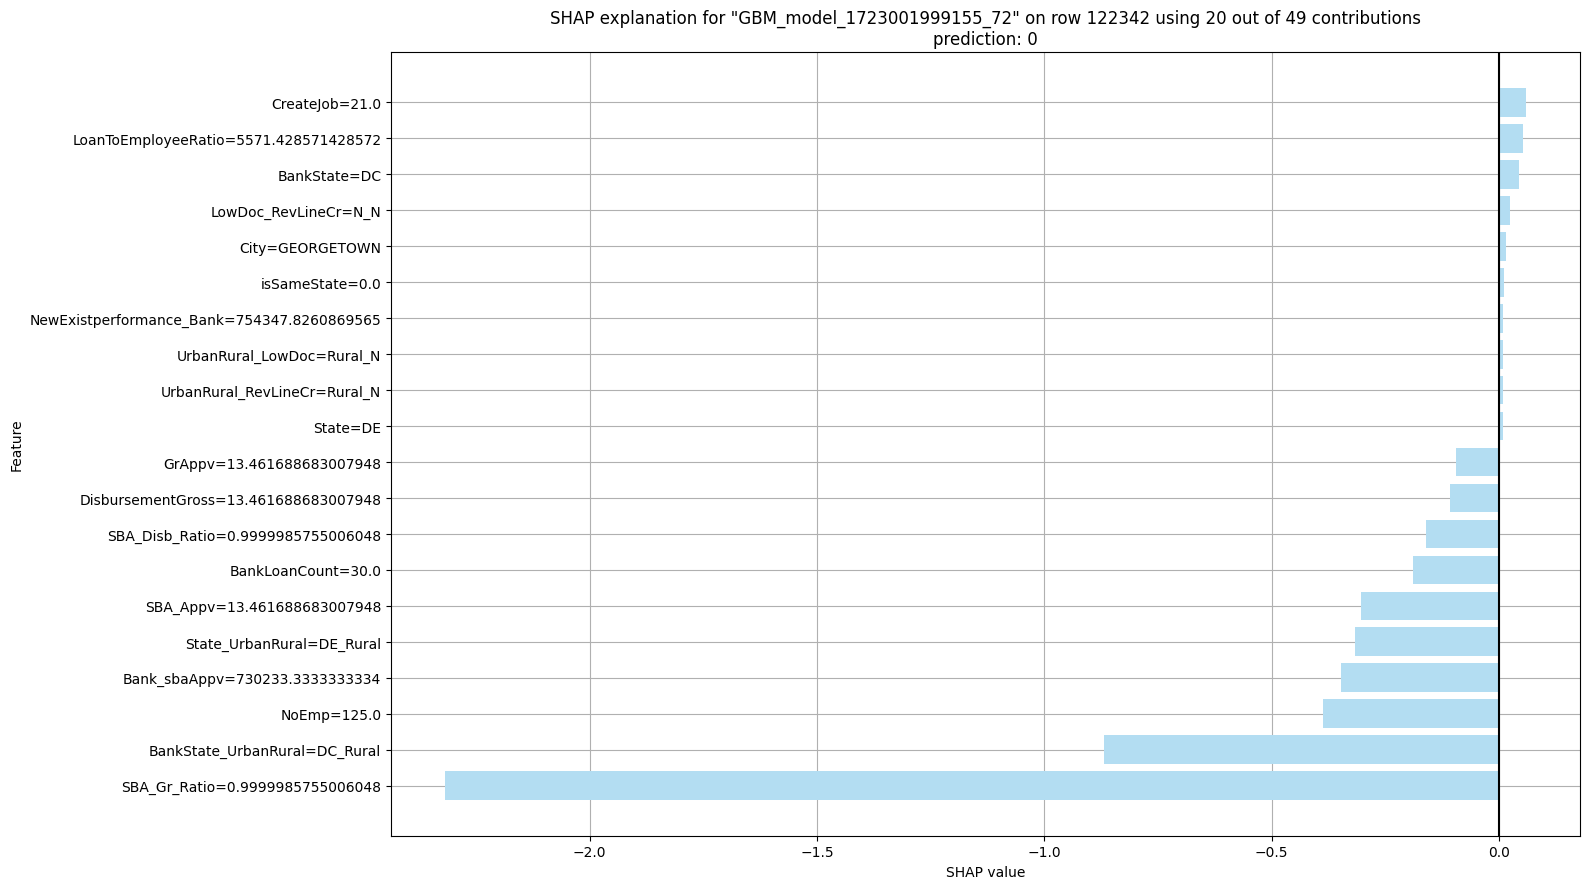

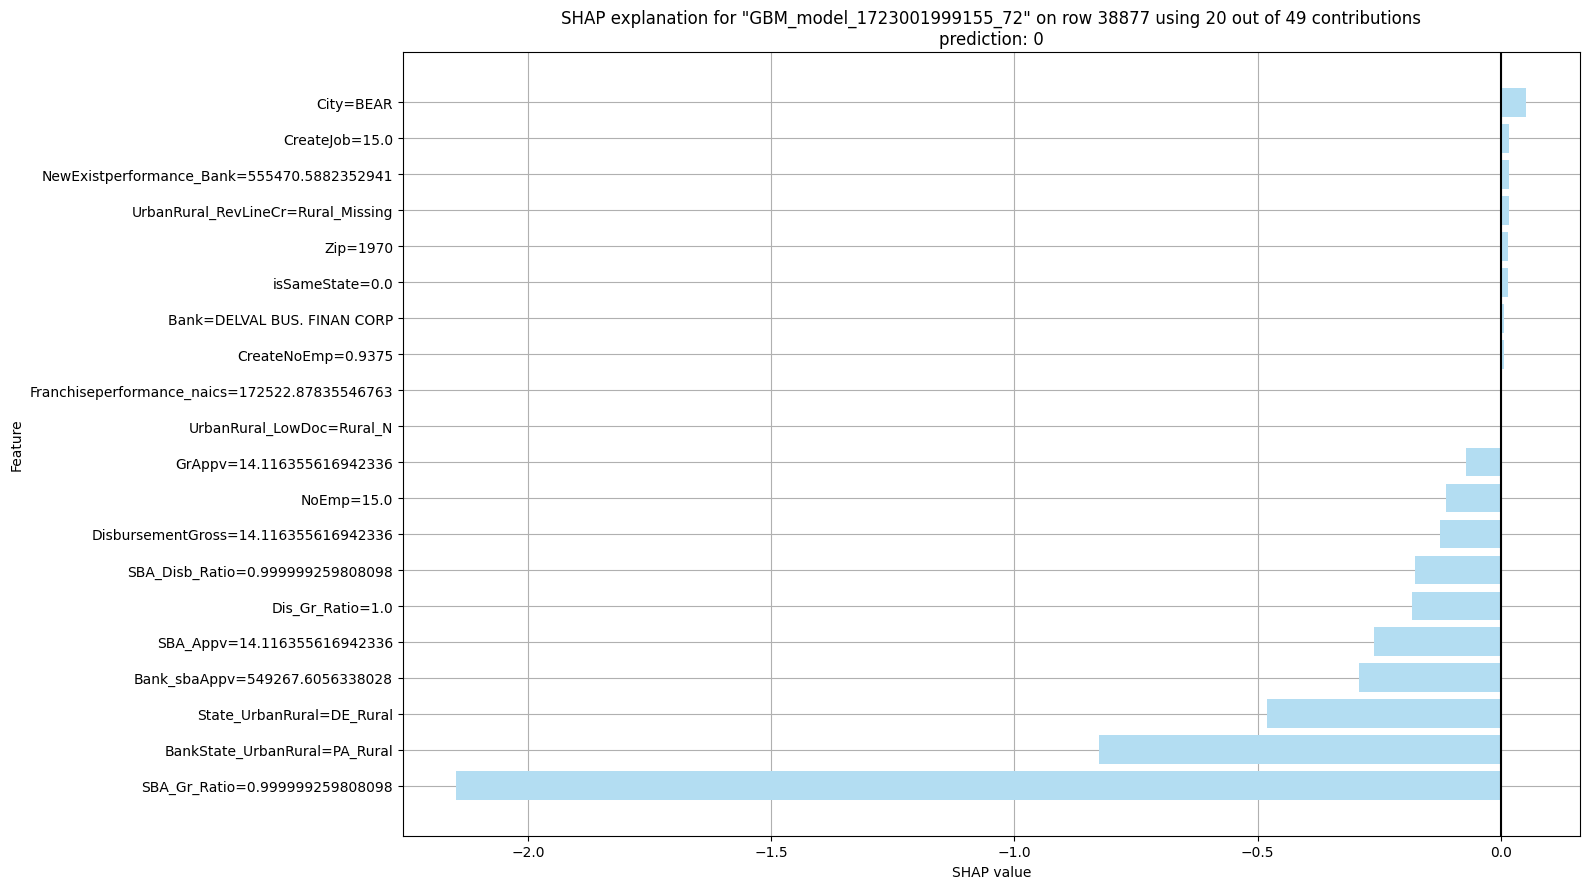

In [36]:
print(correct_0[[response,"p1","predict"]])
calculate_shapley_values(selected_records["correct_0"])

#### For the above two records, we can see that the model has predicted MIS_Status of<span style="color:yellow"> 0 correctly with a very significant low probability of around 0.0007-0.0008</span> indicating it being 0. By observing the SHAP individual plot, we can see that the top two features that has significantly large negative SHAP value are SBA_Gr_Ratio and BankState_UrbanRural. Even excluding the top two features,most of the other features tend to have negative SHAP values strongly contributing to a lower probablity and therefore resulting in the prediction 0. Similarity between these records tend to be that both have Rural status with SBA_Gr_Ratio and Bank_SBA_Appv.

  MIS_Status        p1    predict
           0  0.952945          1
           0  0.938792          1
[2 rows x 3 columns]



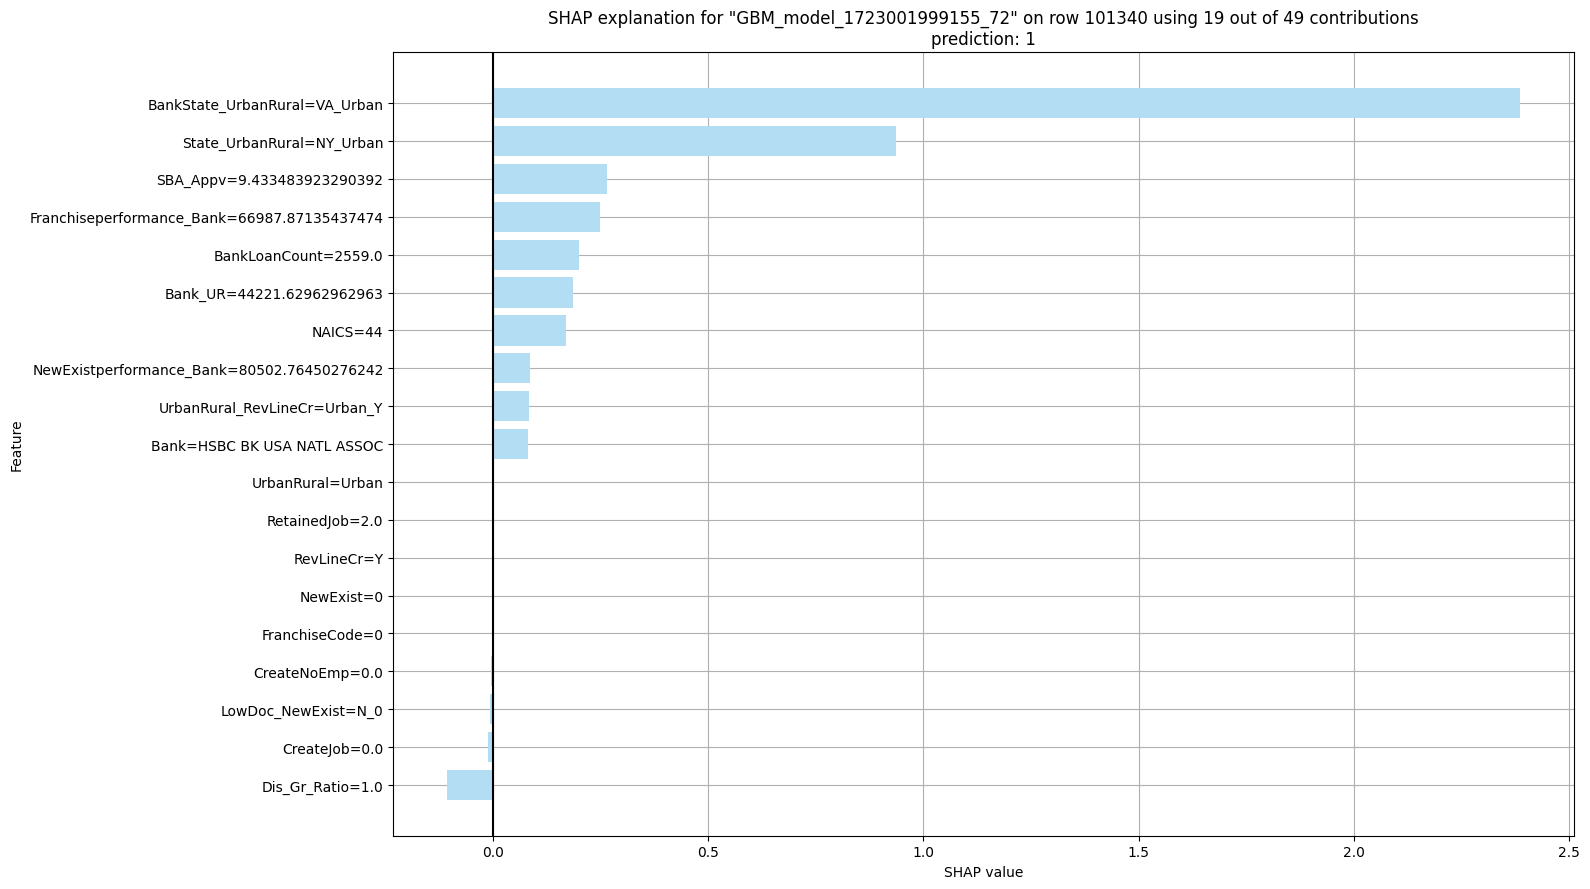

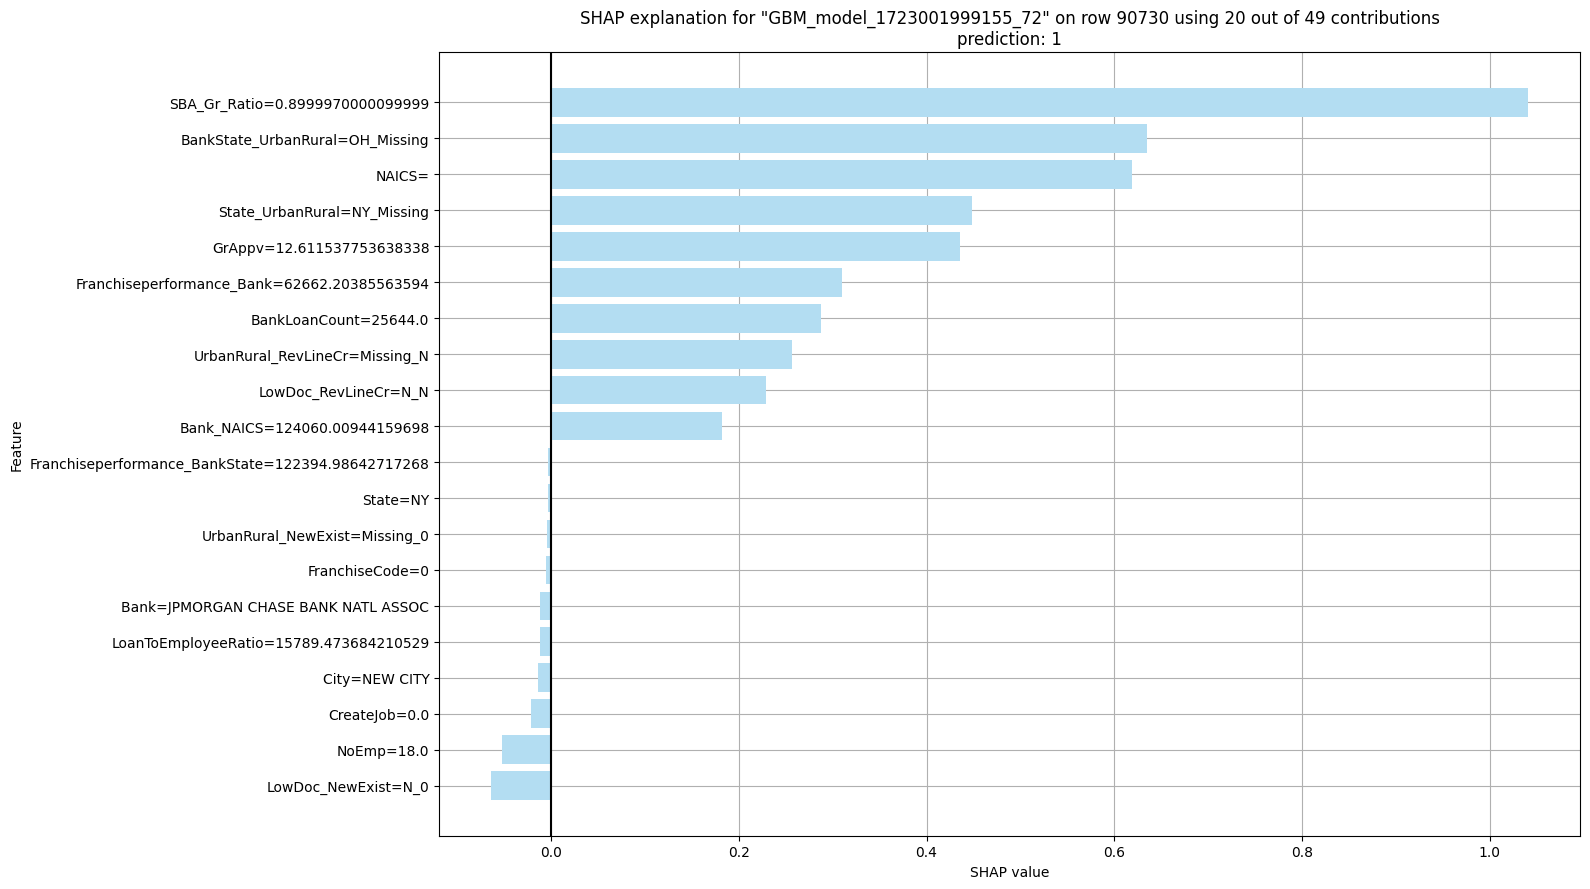

In [37]:
print(incorrect_0[[response,"p1","predict"]])
calculate_shapley_values(selected_records["incorrect_0"])

#### For the above two records, we can see that the model has predicted MIS_Status of <span style="color:yellow">1 incorrectly with a very significant probability of around 0.9 </span>and above while the actual MIS_Status was 0. By observing the SHAP individual plot, we can see that the top two features that has significantly large negative SHAP value are SBA_Gr_Ratio,State_UrbanRural and BankState_UrbanRural. In the first record the prediction was led to being 1 mainly due to the Urban Status of the borrower. In the second plot most of the significant features tend to show a strong positive SHAP Values which has resulted in an incorrect prediction of 1.

  MIS_Status        p1    predict
           1  0.989905          1
           1  0.988358          1
[2 rows x 3 columns]



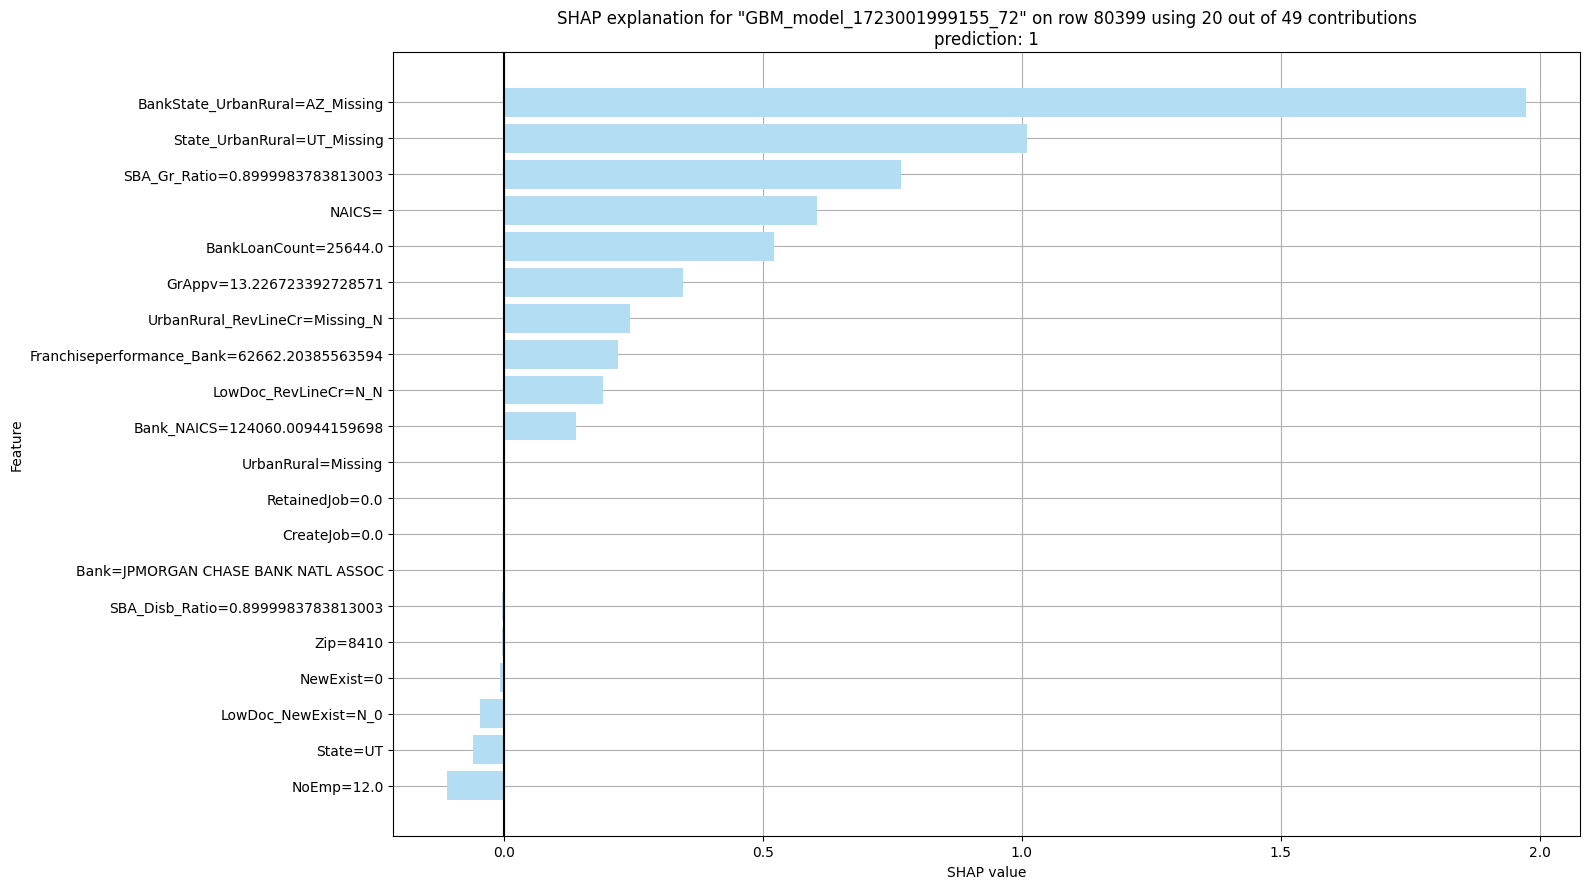

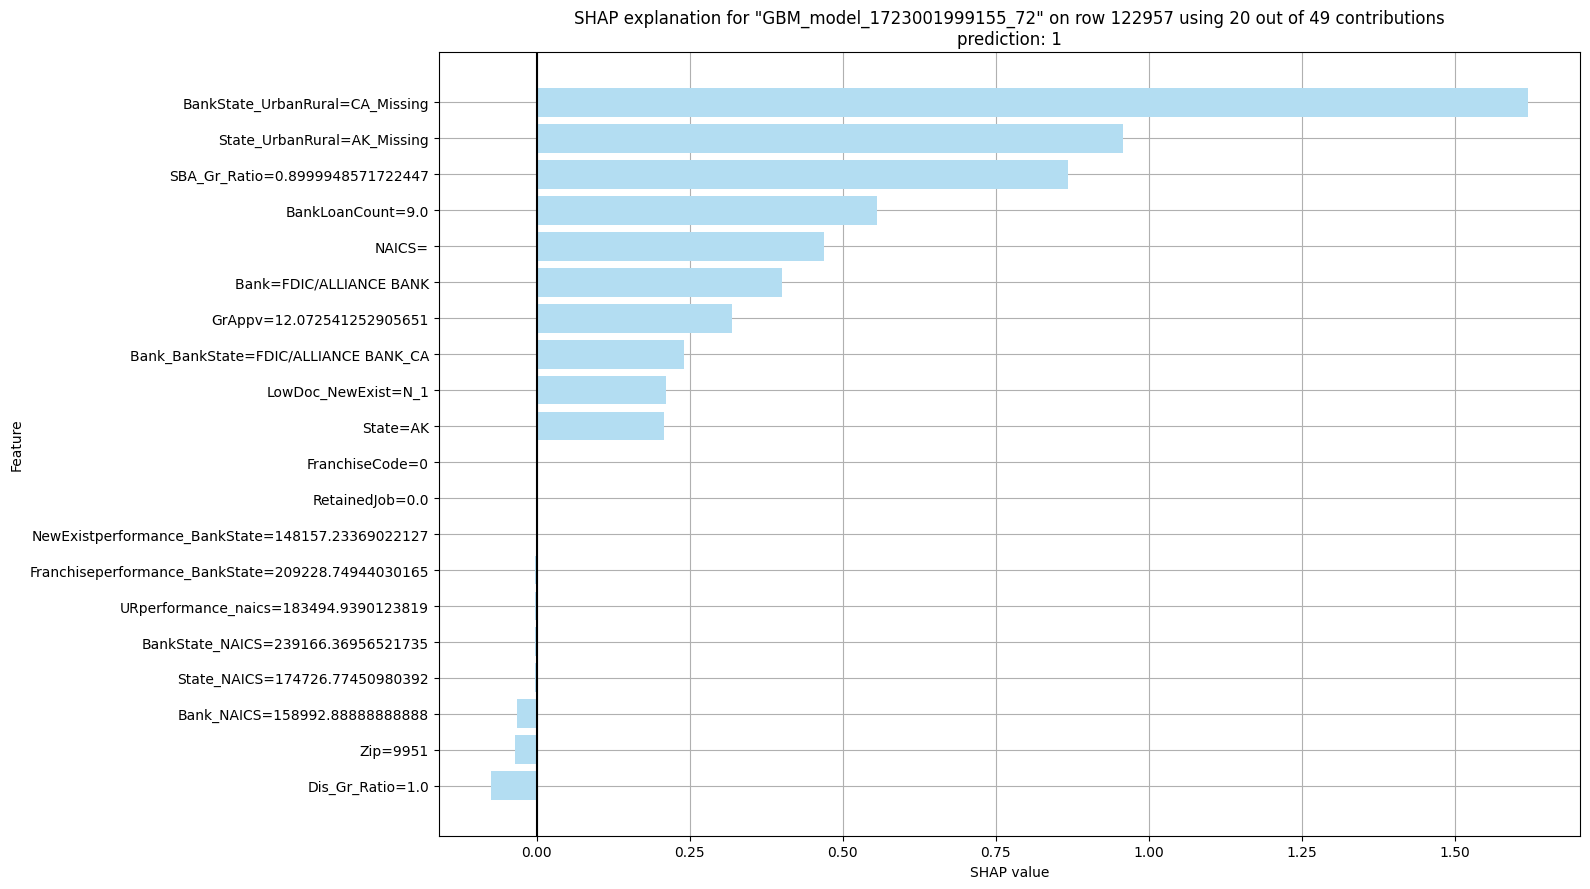

In [38]:
print(correct_1[[response,"p1","predict"]])
calculate_shapley_values(selected_records["correct_1"])

#### For the above two records, we can see that the model has predicted MIS_Status of <span style="color:yellow">1 correctly with a very significant probability of around 0.98</span> indicating it being 1. By observing the SHAP individual plot, we can see that the top two features that has significantly large negative SHAP value are BankState_UrbanRural and State_UrbanRural. Even excluding the top two features,most of the other features tend to have positive SHAP values strongly contributing to a higher probablity and therefore resulting in the prediction 1. Similarity between these records tend to be that both have UrbanRural status seems to be Missing with  a similar SBA_Gr_Ratio.

  MIS_Status          p1    predict
           1  0.00672412          0
           1  0.00858139          0
[2 rows x 3 columns]



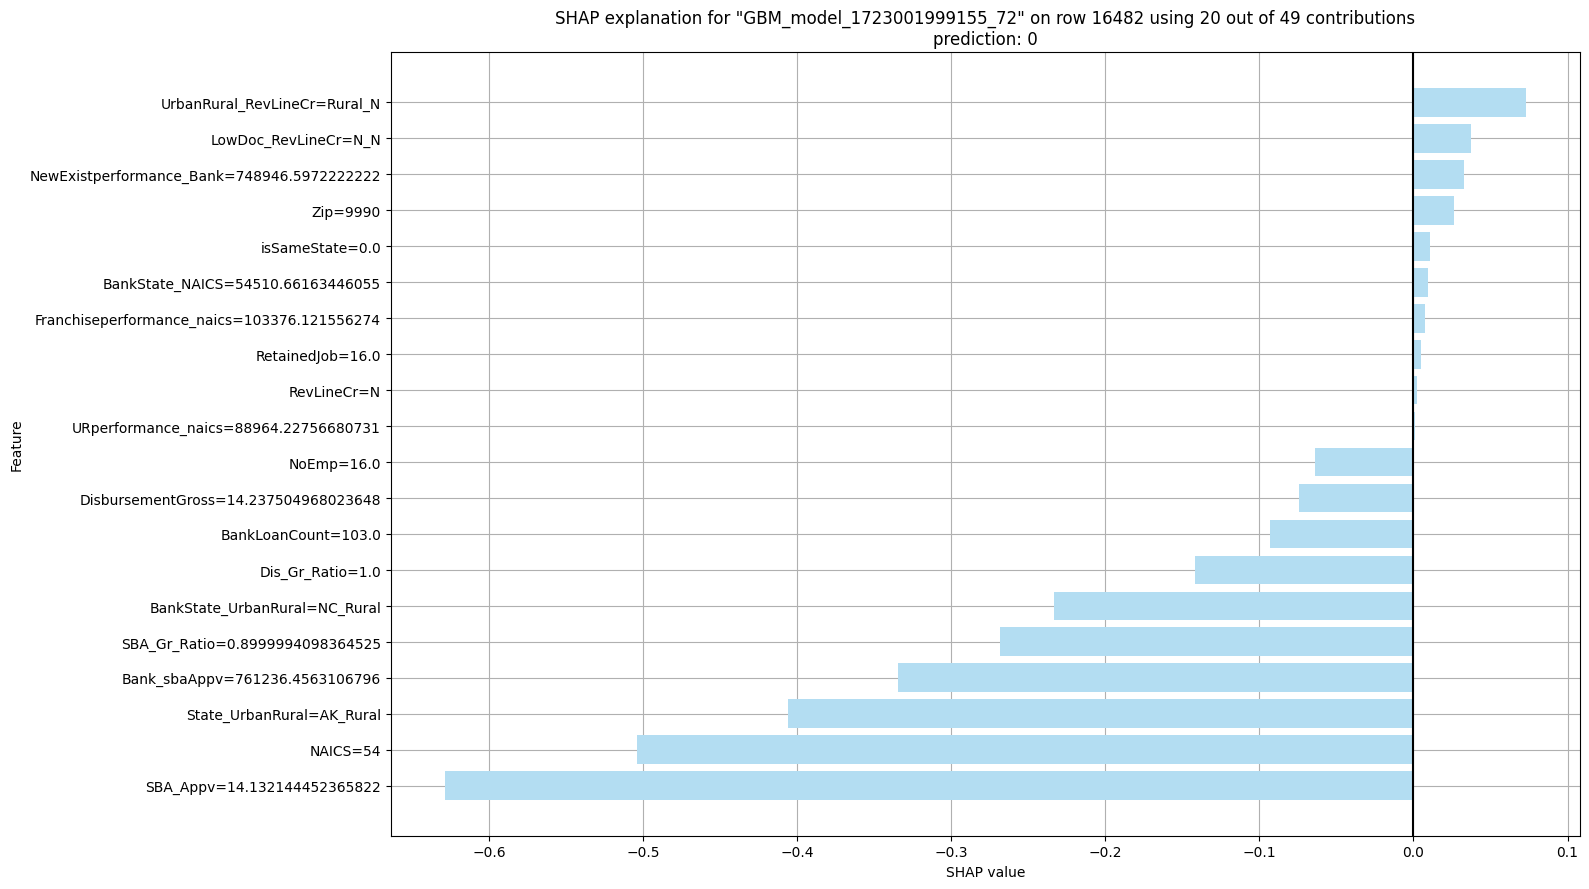

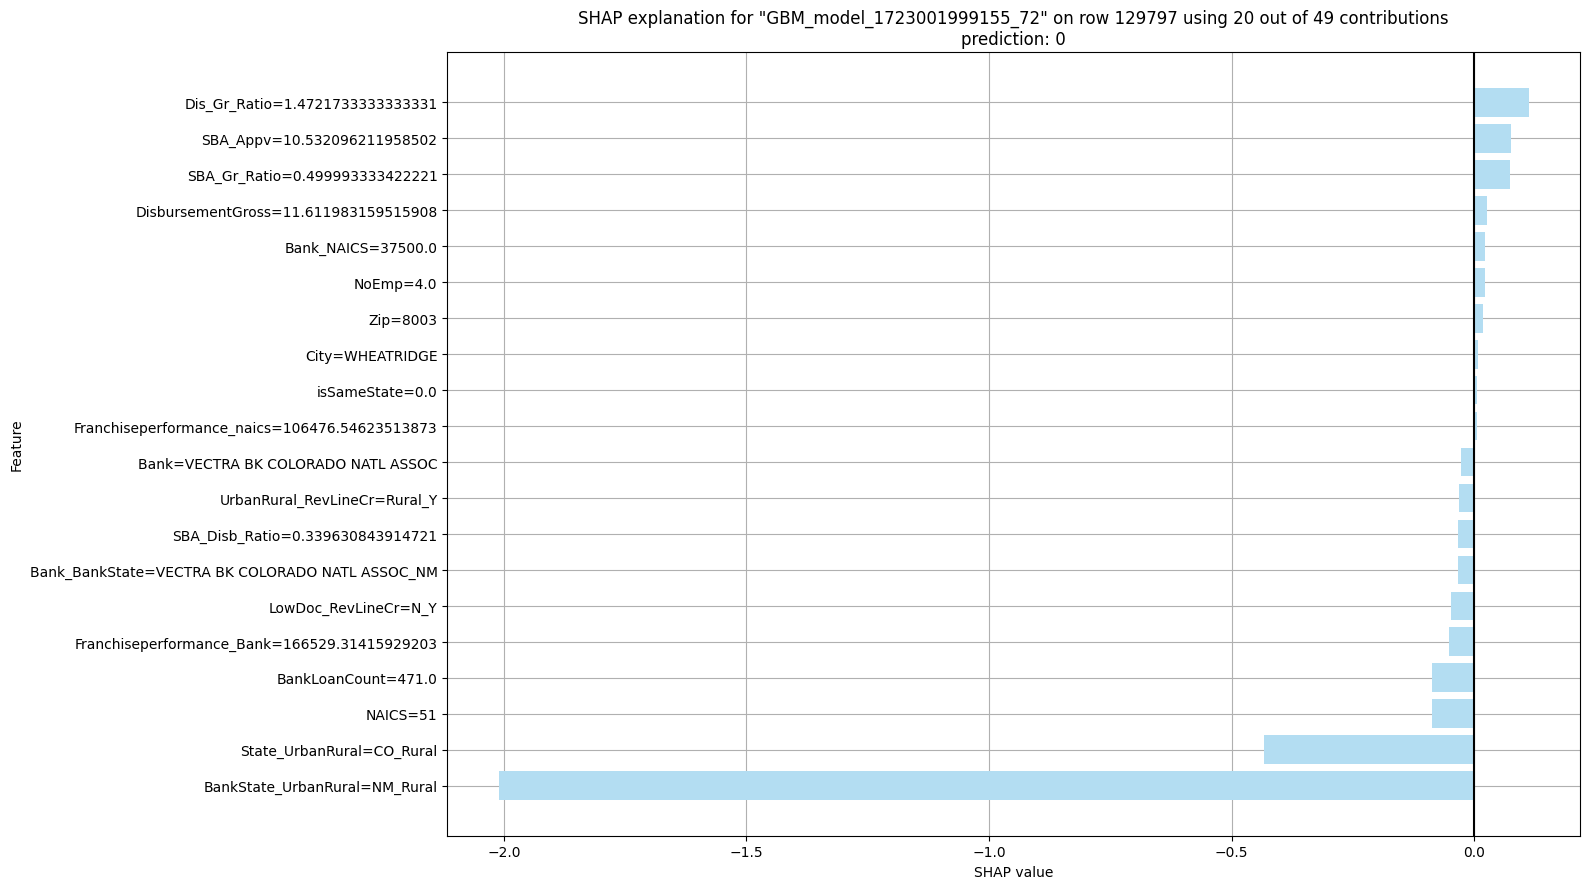

In [39]:
print(incorrect_1[[response,"p1","predict"]])
calculate_shapley_values(selected_records["incorrect_1"])

#### For the above two records, we can see that the model has predicted MIS_Status of <span style="color:yellow">0 incorrectly with a very significant probability of around 0.006</span> indicating it being 0. By observing the SHAP individual plot, we can see that the top two features that has significantly large negative SHAP value are BankState_UrbanRural and State_UrbanRural for the first record and SBA_Appv and NAICS for the second.For the first record even excluding the top two features,most of the other features tend to have negative SHAP values strongly contributing to a lower probablity and therefore resulting in the prediction 0. Similarity between these records tend to be that both have Rural status.

#### Step 19: <span style="color:yellow">Calculate residuals of the predicted probablities using logit function.</span>

In [30]:
# use Pandas for adding columns and plotting
h2o.export_file(test, path="temp1.csv", force=True)

# Read the CSV file into a pandas DataFrame
test_yhat = pd.read_csv("temp1.csv")
test_yhat['s'] = 1
test_yhat.loc[test_yhat['MIS_Status'] == 0, 's'] = -1
test_yhat['Residuals'] = test_yhat['s'] * np.sqrt(-2*(test_yhat[response]*np.log(test_yhat['p1']) +
                                                                 ((1 - test_yhat[response])*np.log(1 - test_yhat['p1']))))
test_yhat = test_yhat.drop('s', axis=1)
test_yhat.head(2)
test_yhatH2o = h2o.H2OFrame(test_yhat)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


#### Step 20: <span style="color:yellow">Sorting the dataframe with residuals in ascending order. The head will have high negative residuals and tail will have highest positive residuals</span>

In [ ]:
test_yhatH2o = test_yhatH2o.sort('Residuals')

#### Step 21: <span style="color:yellow">SHAP summary plot of top 10000 records with least residuals or high negative residuals</span>

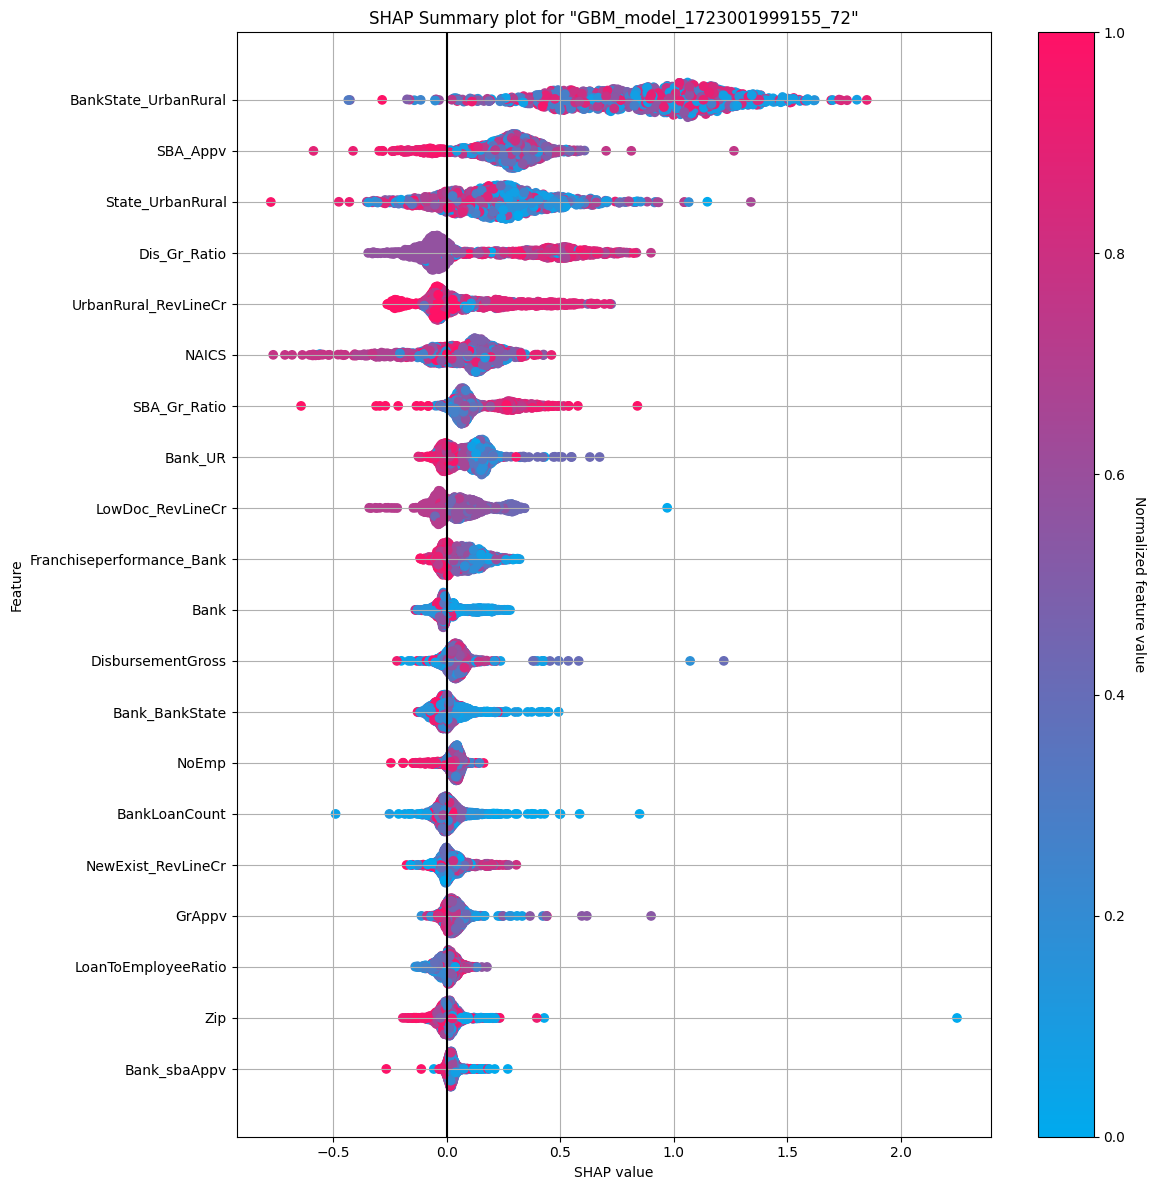

In [31]:
best_model.shap_summary_plot(test_yhatH2o.head(10000))

#### The above SHAP summary is plotted for top 10000 records that has the least residuals(negative residuals).Negative residual indicates that the actual class was 0 but our model predicted 1. If we see the SHAP summary the top features that contributed to this behaviour are:<br/> BankState_UrbanRural - Most of the values have contributed to an increased impact on the response.<br/>SBA_Appv Most of the records had a lower value of SBA_Appv which has contributed to a higher probability.<br/>State_UrbanRural - Most of the records with lesser and moderate values have contributed a positive SHAP to the model leading to a higher probablity.<br/>BankLoanCount - The records with lower values have contributed significantly in a positive direction leading to a higher probability.

#### Step 22: <span style="color:yellow">SHAP summary plot of bottom 10000 records with high positive residuals</span>

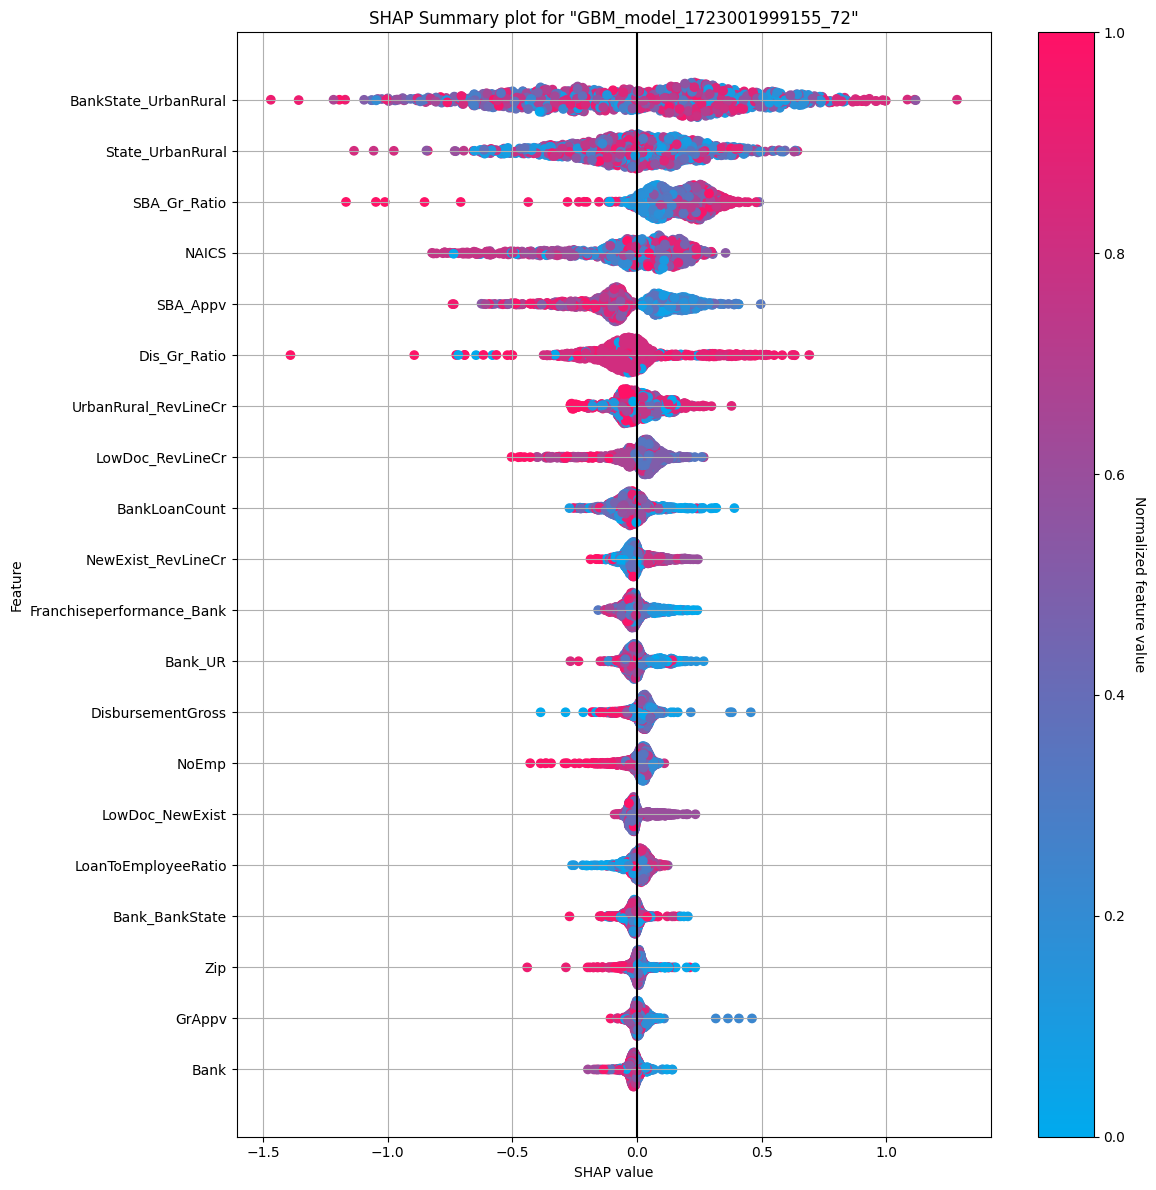

In [32]:
best_model.shap_summary_plot(test_yhatH2o.tail(10000))

#### The above SHAP summary is plotted for bottom 10000 records that has the highest residuals(positive residuals).Positive residual indicates that the actual class was 1 but our model predicted 0. If we see the SHAP summary the top features that contributed to this behaviour are:<br/> State_UrbanRural - Most of the values have contributed to an decreased probability on the response.<br/>SBA_Appv Most of the records had a higher value of SBA_Appv which has contributed to a lower probability/negative impact.<br/>SBA_Appv - Most of the records with higher and moderate values have contributed a negative SHAP to the model leading to a lower probablity.<br/>Dis_Gr_ratio - We see a variability in its contribution. But it looks like values with lower to highly moderate values tend to negatively impact the probability but it is not clear from the plot.

#### From the overall analysis we have to consider how to modify BankState_UrbanRural,State_urbanRural and SBA_Gr_Ratio factors in such a way to decrease the residuals.

#### Step 23: <span style="color:yellow">Storing the functions and data dictionaries into a pickle file in the artifacts folder and also saving the best model into the artifacts folder.</span>

In [33]:
artifacts_dict["threshold"] = optimal_threshold
artifacts_dict["ModelId"] = best_model.model_id

In [34]:
h2o.save_model(model=best_model,path="/content/drive/MyDrive/Colab Notebooks/artifacts",force=True)
artifacts_functions_file = open("/content/drive/MyDrive/Colab Notebooks/artifacts/artifacts_functions_file.pkl", "wb")
pickle.dump(obj=artifacts_functions, file=artifacts_functions_file)
artifacts_functions_file.close()
artifacts_dict_file = open("/content/drive/MyDrive/Colab Notebooks/artifacts/artifacts_dict_file.pkl", "wb")
pickle.dump(obj=artifacts_dict, file=artifacts_dict_file)
artifacts_dict_file.close()

### Summary and Conclusion:
The model tends to have good predictive power with an AUC of 0.826 on the test data set. 
Key metrics on the test data:<br/>
AUC: 0.8265<br/>
F1-score: 0.5239<br/>

Model Characteristics<br/>
Number of trees: 83<br/>
Maximum depth: 10<br/>
Mean depth: 9.87<br/>
Mean leaves: 766<br/>

#### Findings:
The top five most important features in the model are:<br/>
1)BankState_UrbanRural<br/>
2)State_UrbanRural<br/>
3)SBA_Appv<br/>
4)Bank_UR<br/>
5)Dis_Gr_Ratio<br/>
These features contribute significantly to the model's predictive power.
From permutation feature importance we can also see that there are few features that has low contributions or zero contributions to the model, like BalanceGross. 
The engineered features tend to have contributed the most to the model's predictive power with features like BankState_urbanRural, State_urbanRural, Dis_Gr_ratio and SBA_Gr_Ratio being few of the important predictors.
It is also seen from the SHAP summary plots of the residuals and the significant probability records of correct and incorrect records that the most important features are also the ones that are contributing the most to the wrong predictions.
BankState_UrbanRural and State_UrbanRural being the most important features and having too many categories is leading to wrong predictions with high variability in SHAP values.
By looking at the confusion matrix, we can say that the model struggles to predict class 1 as it has an error rate of 41.43%.

#### Recommendations and Future steps:
As model building and debugging is a continuous process, we need to understand the contributions of each feature and carefully remove or modify them to achieve our best model. It should involve a step by step process of adding a small set of features and understanding their importance to the predictions and also to the errors and it is needed to exclude the features that dont contribute well to the model and involve features or interactions that improves the stability and predictive power of the model.  
Further steps can be taken to scale the data or encode categorical variables using different techniques or even use platforms like Driverless AI to achieve different feature interactions and extract important features from them.